<a href="https://colab.research.google.com/github/RH-Pronoy/BlackList/blob/main/PepperBell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas pillow

In [ ]:
!pip install pandas
!pip install opencv-python

In [ ]:
!pip install tensorflow==2.12.0
!pip install keras

In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os
from tensorflow import keras
import glob as gb
import pandas as pd
from tensorflow.keras.preprocessing import image_dataset_from_directory
# Import RandomFlip and RandomRotation from the preprocessing module
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU

In [ ]:
IMG_SIZE = (299, 299) # resolution
directory = "/content/drive/MyDrive/Bangladeshi Crop Diseases detection dataset/Dataset/Pepper__bell Leaf Diseases Dataset From Bangladesh"
BATCH_SIZE = 128
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='training',
                                             color_mode='rgb',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             labels='inferred',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.1,
                                             subset='validation',
                                             color_mode='rgb',
                                             seed=42)

Found 2495 files belonging to 2 classes.
Using 2246 files for training.
Found 2495 files belonging to 2 classes.
Using 249 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

<ipython-input-5-a185a5cc694f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy'], y=Data_imbalance, palette="rocket")


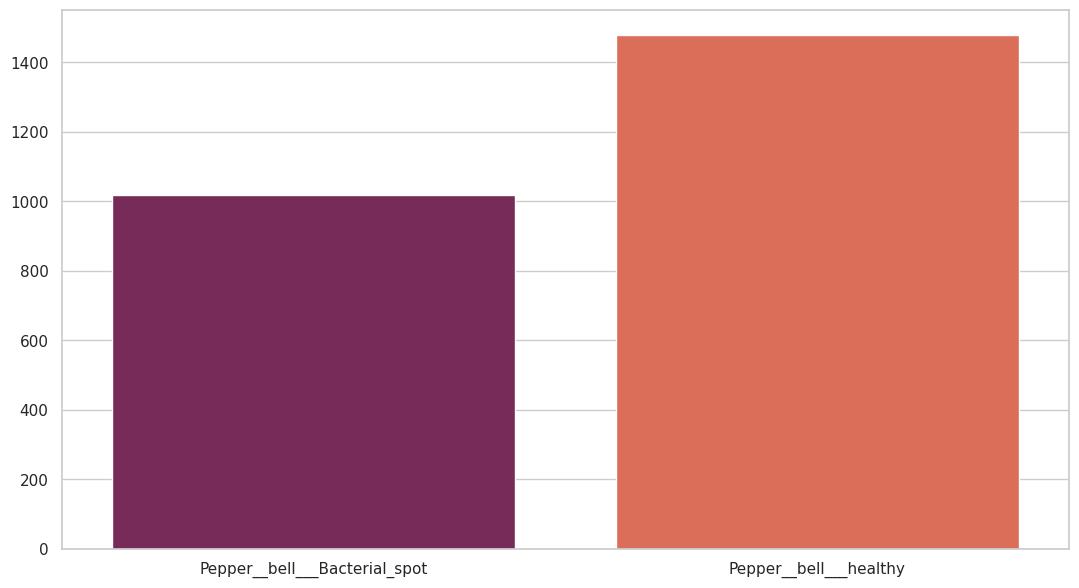

In [ ]:
sns.set_theme(style="whitegrid")
Data_imbalance = []
for folder in os.listdir(directory):
    files = gb.glob(pathname=str(directory + "/" + folder +"/*.*"))
    Data_imbalance.append(len(files))
plt.figure(figsize=(13,7))
sns.barplot(x=['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy'], y=Data_imbalance, palette="rocket")
plt.show()

In [ ]:
total = 0
for i in range(0,len(Data_imbalance)) :
    total +=Data_imbalance[i]

weight_for_0 = (1 / Data_imbalance[0]) * (total / 4.0)
weight_for_1 = (1 / Data_imbalance[1]) * (total / 4.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 0.42


In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomHeight(0.2),
  tf.keras.layers.RandomWidth(0.2),
])

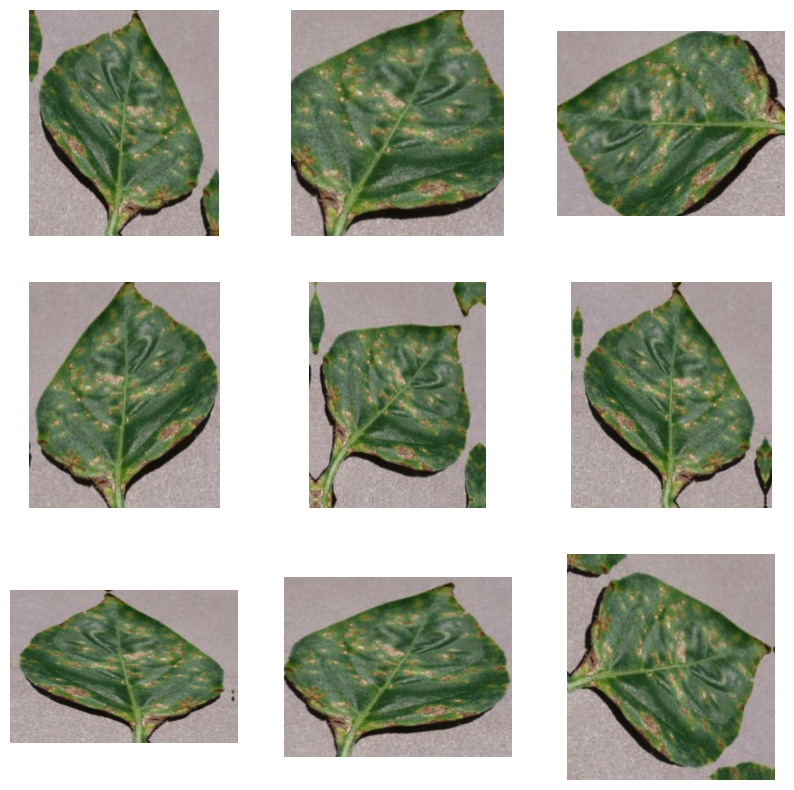

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

**Pepper__bell___Bacterial_spot**

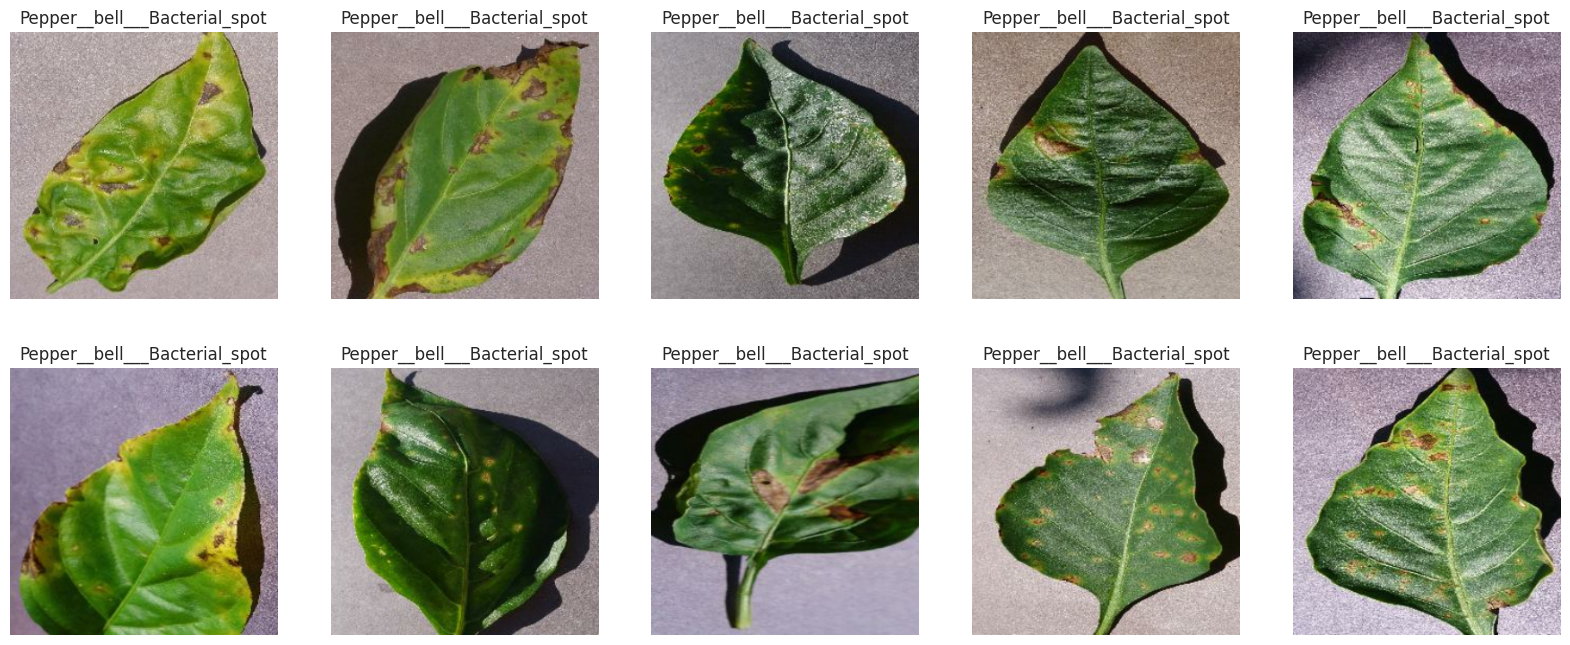

In [ ]:
plt.figure(figsize=(20,8))
Pepper__bell___Bacterial_spot = []
for images , labels in train_dataset.take(1):
    for i in range(100):
        if class_names[labels[i]] == "Pepper__bell___Bacterial_spot":
            Pepper__bell___Bacterial_spot.append(images[i].numpy().astype("uint8"))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(Pepper__bell___Bacterial_spot[i])
    plt.axis("off")
    plt.title("Pepper__bell___Bacterial_spot")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

**Modeling**

In [ ]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
type(base_model)
preprocess_input = tf.keras.applications.inception_v3.preprocess_input

In [ ]:
nb_layers = len(base_model.layers)
print("Numbers of Layers =" , nb_layers)
print(base_model.layers[nb_layers - 2].name)  # pre- Last name
print(base_model.layers[nb_layers - 1].name)

Numbers of Layers = 311
activation_93
mixed10


In [ ]:
# iterate over first batch (32 image) in trainset
image_batch, label_batch = next(iter(train_dataset))  # 32 image arrays
feature_batch = base_model(image_batch)  # run the model on those 32 image (base model with its 1000 causes classification)
print(feature_batch.shape)  # 32 for number of images in this batch and 1000 for classes

(128, 8, 8, 2048)


**Inception V3 (2015)**

In [ ]:
def plant_leaf_model( image_shape=IMG_SIZE):
    ''' Define a tf.keras model for multi-class classification out of the InceptionV3 model '''
    image_shape = image_shape + (3,)

    resnet_model = tf.keras.applications.InceptionV3(input_shape=IMG_SHAPE, include_top= False,weights='imagenet')
    resnet_model.trainable = True
    for layer in resnet_model.layers[0 : 291]:
        layer.trainable = False

    inputs = tf.keras.Input(image_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(inputs)
    x = resnet_model(x , training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    prediction_layer = tf.keras.layers.Dense(4 ,activation = "softmax")
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    model.summary()
    return model

In [ ]:
Plant_Leaf_Model = plant_leaf_model(IMG_SIZE)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

In [ ]:
base_learning_rate = 0.001
Plant_Leaf_Model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=base_learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                           metrics=['accuracy'])

In [ ]:
history = Plant_Leaf_Model.fit(train_dataset , verbose=2 , epochs=10 ,class_weight=class_weight,
                               validation_data=validation_dataset , use_multiprocessing= True)

Epoch 1/10
18/18 - 419s - loss: 0.3915 - accuracy: 0.7471 - val_loss: 0.1543 - val_accuracy: 0.9438 - 419s/epoch - 23s/step
Epoch 2/10
18/18 - 391s - loss: 0.0638 - accuracy: 0.9550 - val_loss: 0.1129 - val_accuracy: 0.9719 - 391s/epoch - 22s/step
Epoch 3/10
18/18 - 384s - loss: 0.0314 - accuracy: 0.9804 - val_loss: 0.0532 - val_accuracy: 0.9839 - 384s/epoch - 21s/step
Epoch 4/10
18/18 - 389s - loss: 0.0175 - accuracy: 0.9924 - val_loss: 0.0356 - val_accuracy: 0.9920 - 389s/epoch - 22s/step
Epoch 5/10
18/18 - 385s - loss: 0.0106 - accuracy: 0.9951 - val_loss: 0.0272 - val_accuracy: 0.9920 - 385s/epoch - 21s/step
Epoch 6/10
18/18 - 384s - loss: 0.0075 - accuracy: 0.9987 - val_loss: 0.0188 - val_accuracy: 0.9920 - 384s/epoch - 21s/step
Epoch 7/10
18/18 - 390s - loss: 0.0049 - accuracy: 1.0000 - val_loss: 0.0169 - val_accuracy: 0.9920 - 390s/epoch - 22s/step
Epoch 8/10
18/18 - 388s - loss: 0.0035 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 0.9920 - 388s/epoch - 22s/step
Epoch 9/

In [ ]:
Plant_Leaf_Model.evaluate(validation_dataset , verbose = 1)

2/2 [==============================] - 38s 18s/step - loss: 0.0117 - accuracy: 0.9920


[0.01169600524008274, 0.9919678568840027]

1/1 [==============================] - 0s 150ms/step


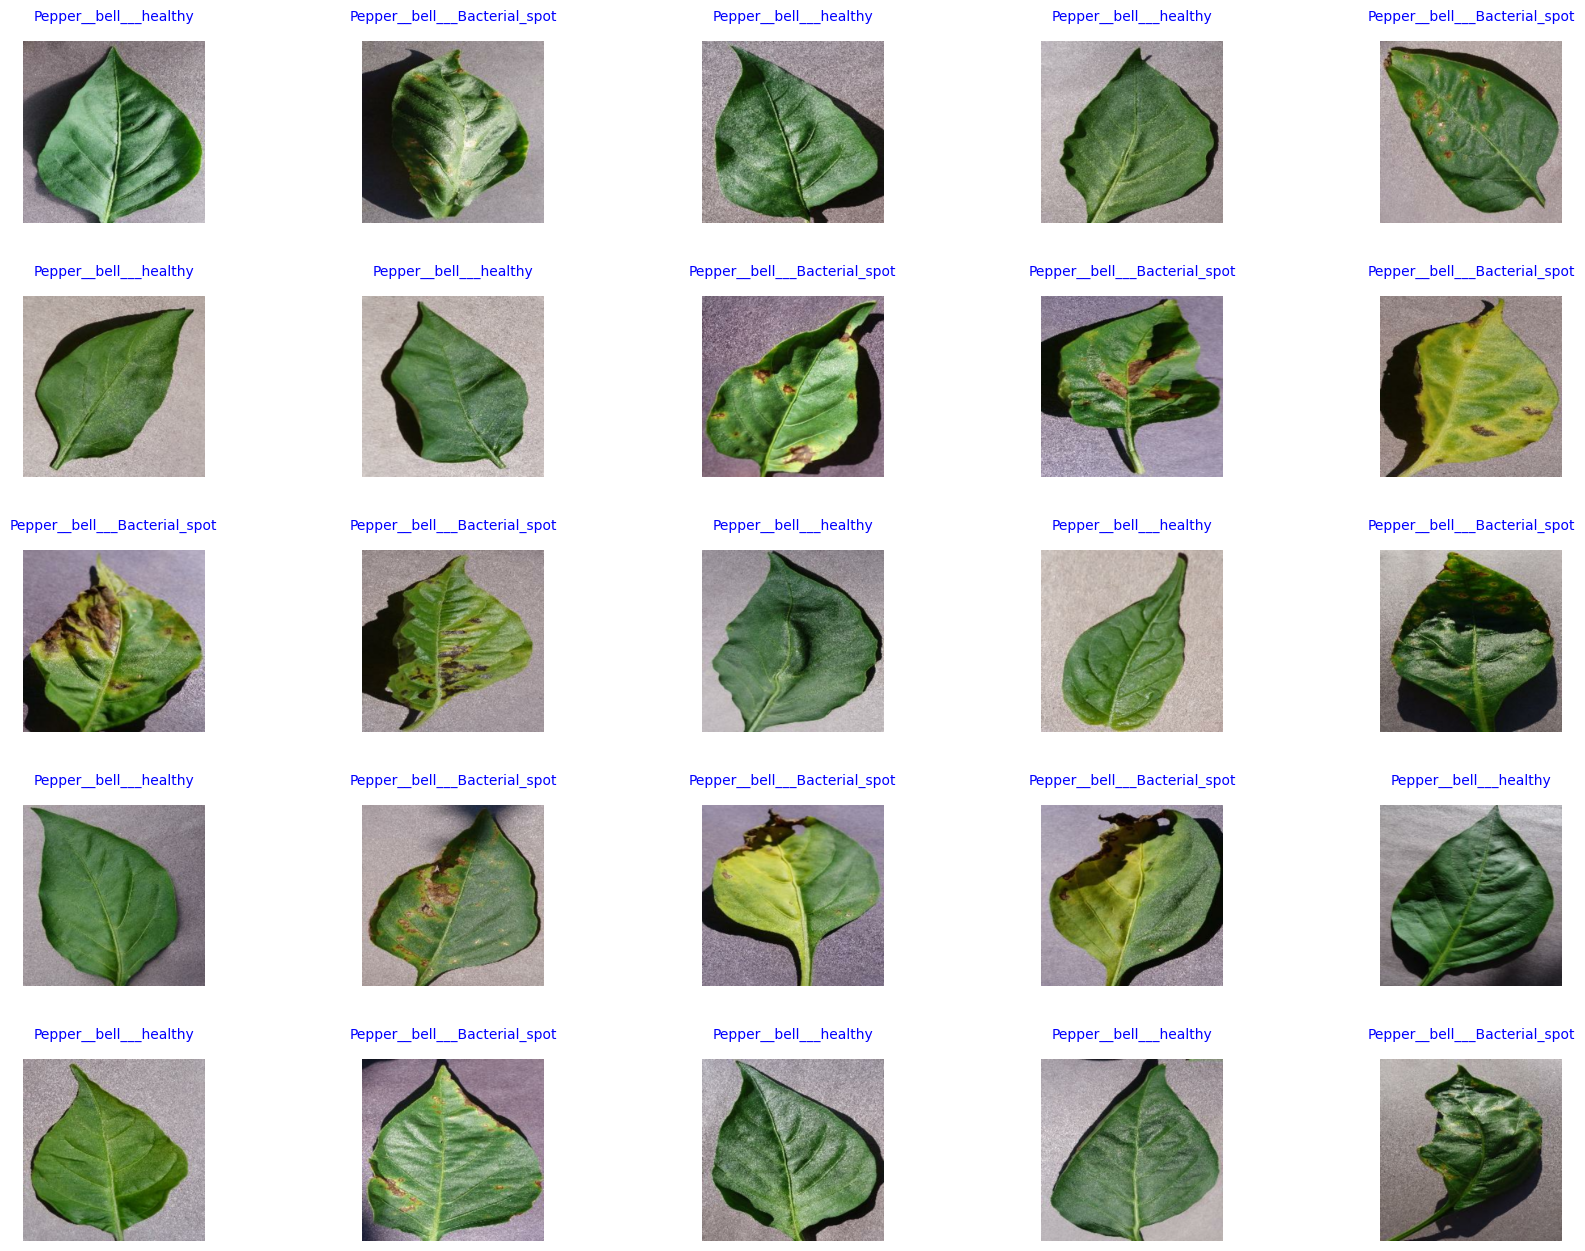

In [ ]:
plt.figure(figsize=(20, 15))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        im2 = images[i].numpy().astype("uint8")
        img2 = tf.expand_dims(im2, 0)
        predict = Plant_Leaf_Model.predict(img2)
        predicted= class_names[np.argmax(predict)]
        actual = class_names [labels[i].numpy().astype("uint8")]
        if (actual == predicted):
            plt.title(predicted, fontsize=10, color= 'blue', pad=15);
        else :
            plt.title(actual, fontsize=10, color= 'red' ,pad=15);
        plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9,
                            top=0.9, wspace=0.4,hspace=0.4)

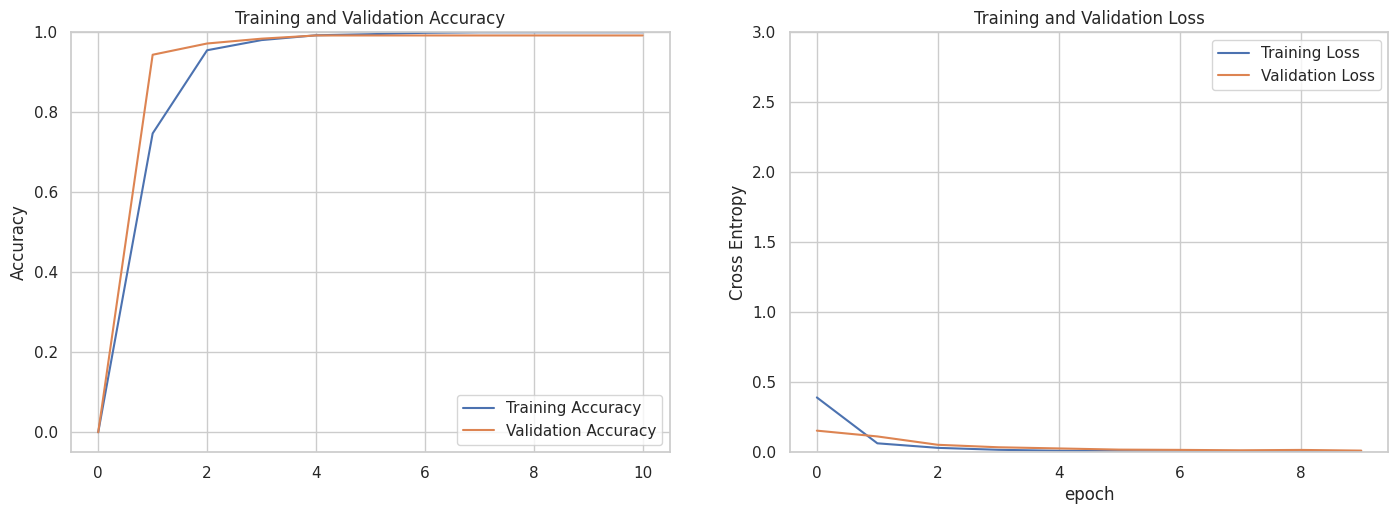

In [ ]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(17, 12))
plt.subplot(2, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

4/4 [==============================] - 19s 4s/step


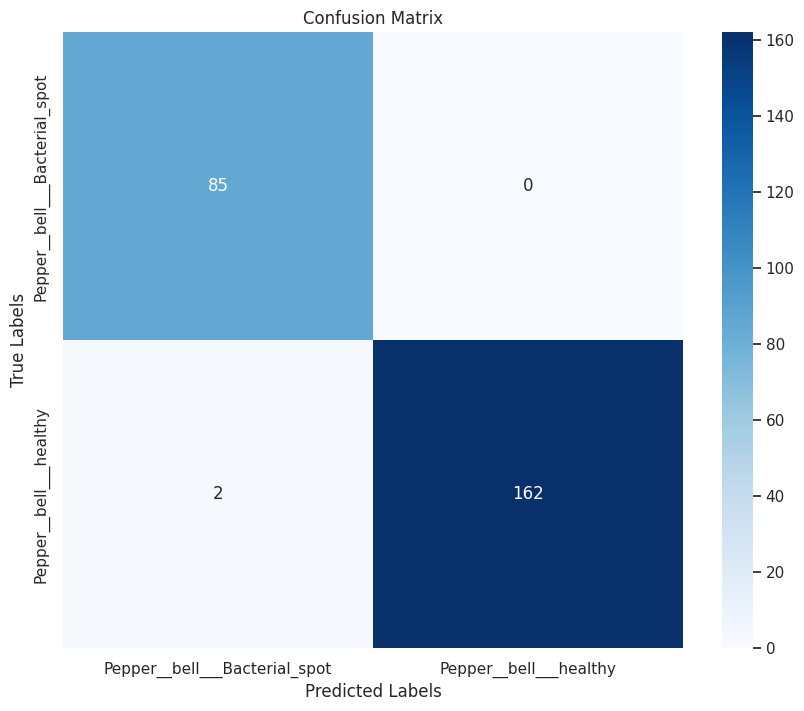

Confusion Matrix:
[[ 85   0]
 [  2 162]]


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Get the true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in validation_dataset:
    predictions = Plant_Leaf_Model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix separately
print("Confusion Matrix:")
print(conf_matrix)




In [ ]:
# Print classification report separately
print("Classification Report:")
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

Classification Report:
                               precision    recall  f1-score   support

Pepper__bell___Bacterial_spot       0.98      1.00      0.99        85
       Pepper__bell___healthy       1.00      0.99      0.99       164

                     accuracy                           0.99       249
                    macro avg       0.99      0.99      0.99       249
                 weighted avg       0.99      0.99      0.99       249

